In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [3]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2

In [4]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [5]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [6]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_plateau_length(
    steps: List[Dict], threshold: float = 0.005, window_size: int = 5
) -> int:
    kl_divs = [step["kl_div"] for step in steps]

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(kl_divs) - window_size + 1):
        window = kl_divs[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    steps: List[Dict], threshold: float = 5e-05, window_size: int = 5
) -> int:
    js_divs = [step["js_div"] for step in steps]

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_divs) - window_size + 1):
        window = js_divs[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1

In [7]:
metadata, activations = [], []

for path in glob("observations/metadata*"):
    metadata.extend(load_jsonl(path))

for path in glob("observations/acts*"):
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [8]:
len(metadata), activations.shape

(5000, (5000, 100, 768))

## Feature Dynamics

In [100]:
feature_activations = []

example_idx = 19

for i, s in enumerate(metadata[example_idx]["steps_metadata"]):
    active_feature_ids = s["active_feature_ids"]
    active_feature_acts = s["active_feature_acts"]
    feature_acts = torch.zeros(sae.W_enc.shape[1])
    feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
    feature_activations.append(feature_acts)

feature_activations = torch.stack(feature_activations)

In [101]:
row_indices = np.arange(feature_activations.shape[0])[:, np.newaxis]
top_features_per_step = np.argsort(feature_activations)[:, -5:]
top_features_acts = feature_activations[row_indices, top_features_per_step]

gradients = np.gradient(top_features_acts, axis=0)
accelerations = np.gradient(gradients, axis=0)

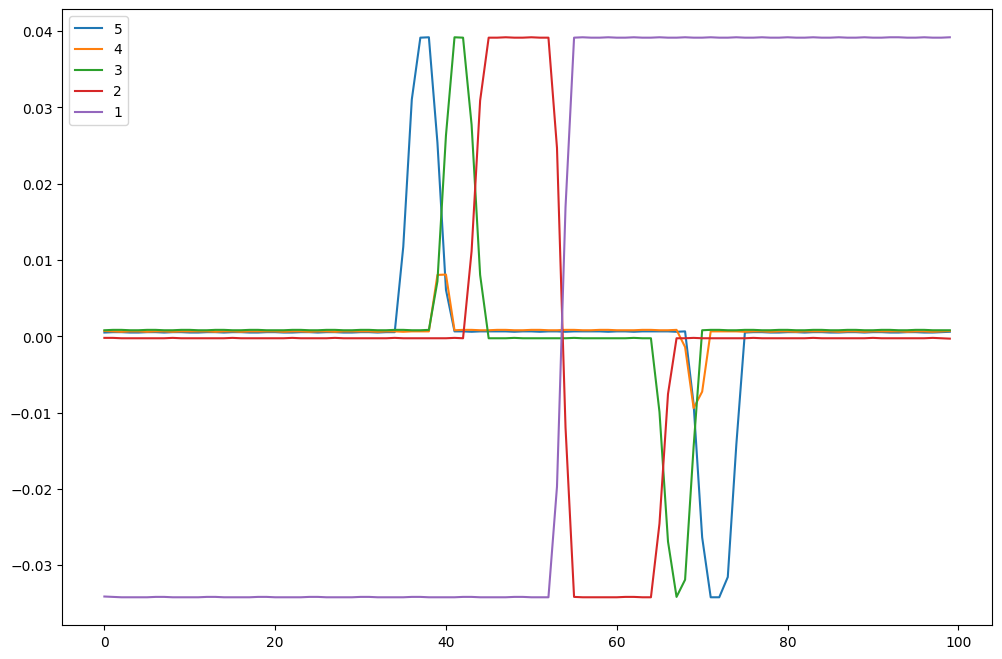

In [105]:
plt.figure(figsize=(12, 8))

for feature_idx in range(5):
    plt.plot(gradients[:, feature_idx], label=5 - feature_idx)

plt.legend()
plt.show()

In [ ]:
def analyze_blowup_dynamics(perturbations_data):
    # Assuming perturbations_data is a list of dictionaries, each containing:
    # 'steps': list of 100 steps
    # 'activations': list of 100 activation vectors
    # 'active_features': list of 100 sets of active feature IDs
    # 'feature_activations': list of 100 dictionaries mapping feature ID to activation level
    # 'kl_divergence': list of 100 KL divergence values

    # 1. Classify blowups
    blowup_steps = [
        np.argmax(p["kl_divergence"] > threshold) for p in perturbations_data
    ]
    median_blowup = np.median(blowup_steps)
    early_blowups = [i for i, step in enumerate(blowup_steps) if step < median_blowup]
    late_blowups = [i for i, step in enumerate(blowup_steps) if step >= median_blowup]

    # 2. Feature Activation Trajectory Analysis
    def analyze_feature_trajectories(perturbation):
        initial_active = set(perturbation["active_features"][0])
        trajectories = {"dampened": [], "activated": [], "rate_of_change": []}
        for step in range(1, 100):
            current_active = set(perturbation["active_features"][step])
            dampened = initial_active - current_active
            activated = current_active - initial_active
            trajectories["dampened"].append(len(dampened))
            trajectories["activated"].append(len(activated))

            prev_activations = perturbation["feature_activations"][step - 1]
            curr_activations = perturbation["feature_activations"][step]
            changes = [
                abs(curr_activations.get(f, 0) - prev_activations.get(f, 0))
                for f in set(curr_activations) | set(prev_activations)
            ]
            trajectories["rate_of_change"].append(np.mean(changes))
        return trajectories

    early_trajectories = [
        analyze_feature_trajectories(perturbations_data[i]) for i in early_blowups
    ]
    late_trajectories = [
        analyze_feature_trajectories(perturbations_data[i]) for i in late_blowups
    ]

    # 3. Critical Step Identification
    def find_critical_step(kl_divergence, window=5):
        changes = np.diff(kl_divergence)
        avg_changes = np.convolve(changes, np.ones(window), "valid") / window
        return np.argmax(avg_changes) + window // 2

    critical_steps = [
        find_critical_step(p["kl_divergence"]) for p in perturbations_data
    ]

    # 4. Pre-Blowup Feature Analysis
    def pre_blowup_features(perturbation, critical_step, window=5):
        start = max(0, critical_step - window)
        active_features = set.union(
            *[
                set(perturbation["active_features"][i])
                for i in range(start, critical_step)
            ]
        )
        avg_activations = {
            f: np.mean(
                [
                    perturbation["feature_activations"][i].get(f, 0)
                    for i in range(start, critical_step)
                ]
            )
            for f in active_features
        }
        return avg_activations

    early_pre_blowup = [
        pre_blowup_features(perturbations_data[i], critical_steps[i])
        for i in early_blowups
    ]
    late_pre_blowup = [
        pre_blowup_features(perturbations_data[i], critical_steps[i])
        for i in late_blowups
    ]

    # 5. Feature Interaction Dynamics
    def extract_feature_interactions(perturbation, critical_step, top_n=10):
        pre_critical = perturbation["feature_activations"][critical_step - 1]
        top_features = sorted(pre_critical, key=pre_critical.get, reverse=True)[:top_n]
        return [pre_critical.get(f, 0) for f in top_features]

    X = np.array(
        [
            extract_feature_interactions(perturbations_data[i], critical_steps[i])
            for i in range(len(perturbations_data))
        ]
    )
    y = np.array(
        [1 if i in early_blowups else 0 for i in range(len(perturbations_data))]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    feature_importance = pd.DataFrame(
        {
            "feature": [f"Feature_{i}" for i in range(X.shape[1])],
            "importance": clf.feature_importances_,
        }
    ).sort_values("importance", ascending=False)

    print("\nTop 10 Important Features for Predicting Early Blowups:")
    print(feature_importance.head(10))

    # Visualizations
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title("Feature Dampening")
    plt.plot(
        np.mean([t["dampened"] for t in early_trajectories], axis=0),
        label="Early Blowups",
    )
    plt.plot(
        np.mean([t["dampened"] for t in late_trajectories], axis=0),
        label="Late Blowups",
    )
    plt.legend()

    plt.subplot(132)
    plt.title("Feature Activation")
    plt.plot(
        np.mean([t["activated"] for t in early_trajectories], axis=0),
        label="Early Blowups",
    )
    plt.plot(
        np.mean([t["activated"] for t in late_trajectories], axis=0),
        label="Late Blowups",
    )
    plt.legend()

    plt.subplot(133)
    plt.title("Rate of Feature Activation Change")
    plt.plot(
        np.mean([t["rate_of_change"] for t in early_trajectories], axis=0),
        label="Early Blowups",
    )
    plt.plot(
        np.mean([t["rate_of_change"] for t in late_trajectories], axis=0),
        label="Late Blowups",
    )
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Heatmap of pre-blowup feature activations
    early_matrix = np.array([list(f.values()) for f in early_pre_blowup])
    late_matrix = np.array([list(f.values()) for f in late_pre_blowup])

    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    sns.heatmap(early_matrix, cmap="viridis")
    plt.title("Early Blowups: Pre-Blowup Feature Activations")

    plt.subplot(122)
    sns.heatmap(late_matrix, cmap="viridis")
    plt.title("Late Blowups: Pre-Blowup Feature Activations")

    plt.tight_layout()
    plt.show()


# Run the analysis
analyze_blowup_dynamics(perturbations_data)